In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from tqdm.auto import tqdm

In [3]:
import sys
sys.path.append("scripts")
import rr_em

In [4]:
coef_mean = torch.tensor([-1.])
coef_sigma = torch.tensor([0.1])
params = rr_em.rr.ModelParameters(
    lambda_=pyro.deterministic("lambda", torch.tensor(1.0)),
    confusion=rr_em.generator.phoneme_confusion,
    threshold=pyro.sample("threshold",
                          dist.Beta(1.2, 1.2)),

    # NB only used for generation, not in model
    a=pyro.deterministic("a", torch.tensor(0.2)),  # unif_categorical_rv("a", torch.tensor([0.3, 0.4, 0.5])),
    b=pyro.deterministic("b", torch.tensor(0.1)), # unif_categorical_rv("b", torch.tensor([0.05, 0.1, 0.15, 0.2])),
    coef=pyro.deterministic("coef", coef_mean),  # pyro.sample("coef", dist.Normal(coef_mean, coef_sigma)),
    sigma=pyro.deterministic("sigma", torch.tensor(5.0)),
    # sigma=pyro.sample("sigma", dist.Uniform(0.5, 1.2))
    # sigma=torch.tensor(1.0),
)

In [5]:
stim = rr_em.stimulus.RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=params.confusion.shape[0],
                                              word_surprisal_params=(2.0, 0.5))
ds_args = dict(response_type="gaussian", epoch_window=(0.0, 1.0), include_intercept=False, sample_rate=48)
dataset = rr_em.generator.sample_dataset(params, stim, **ds_args)
test_dataset = rr_em.generator.sample_dataset(dataset.params, stim, **ds_args)

In [6]:
dataset.Y_epoch[:, :, 0]

tensor([[ 0.8022, -5.1744, -5.5791,  ..., -1.7949,  9.6882, -5.3767],
        [ 1.2529,  7.2590,  0.6567,  ...,  5.3748, -2.6453, -2.6923],
        [-2.6453, -2.6923, -3.5530,  ..., -1.9077, -2.9899, -7.1304],
        ...,
        [-4.3589, -1.0314,  2.0004,  ...,  4.4280,  5.4357, -2.5462],
        [ 1.0385,  0.1272, -3.5475,  ..., -4.1302,  4.2994,  2.6396],
        [ 0.4742, -2.5767,  8.4147,  ...,  4.9057,  0.0847,  4.0506]])

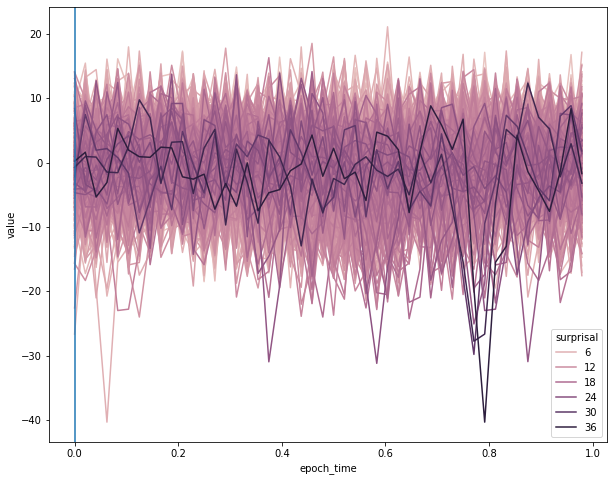

In [7]:
to_plot = pd.DataFrame(dataset.Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_epoch[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += dataset.epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='surprisal', ylabel='Density'>

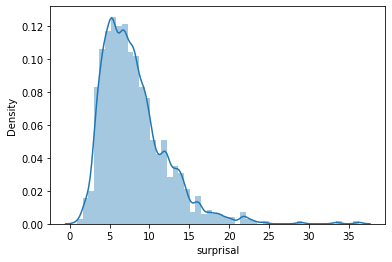

In [8]:
sns.distplot(to_plot.surprisal)

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

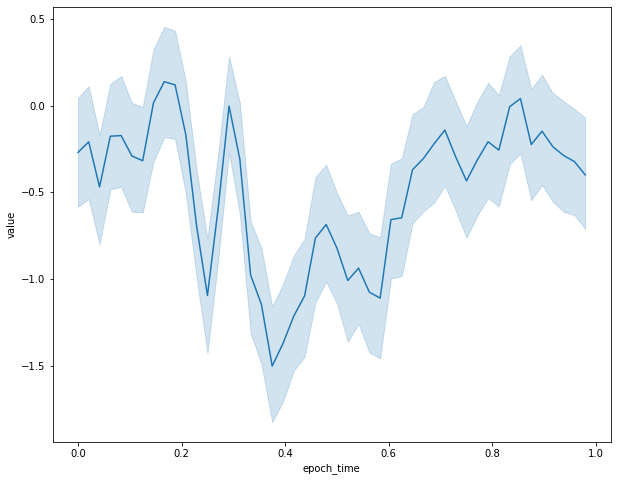

In [9]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value")

## MLE regression

Raw visualization above doesn't produce a very clean EEG response. Let's try estimating a TRF model on the full data and see if we can recover something.

In [10]:
from sklearn.model_selection import ShuffleSplit

n_splits = 10
tmin, tmax = 0.0, 1.0
encoder = rr_em.TemporalReceptiveField(tmin, tmax, dataset.sample_rate, ["abc"], alpha=0)
n_features = dataset.X_epoch.shape[1]
coefs = torch.zeros((n_splits, len(encoder.delays_), n_features))

X_scatter = rr_em.rr.scatter_response_model(
    dataset.X_epoch,
    torch.zeros(dataset.X_epoch.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])

idxs = torch.arange(X_scatter.shape[0])
split_size = X_scatter.shape[0] // n_splits
split_offsets = torch.arange(n_splits) * split_size
for i_split, offset in enumerate(tqdm(split_offsets)):
    idxs_i = idxs[offset:offset + split_size]
    encoder_i = encoder.fit(X_scatter[idxs_i], dataset.Y[idxs_i])
    coefs[i_split] = encoder_i.coef_

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
coef_df = pd.DataFrame(coefs[:, :, 0])
coef_df.index.name = "fold"
coef_df = coef_df.reset_index().melt(id_vars=["fold"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,fold,epoch_sample,value,epoch_time
0,0,0,0.023041,0.0
1,1,0,-0.008495,0.0
2,2,0,0.021370,0.0
3,3,0,0.068900,0.0
4,4,0,-0.012694,0.0
...,...,...,...,...
485,5,48,0.005791,1.0
486,6,48,-0.048613,1.0
487,7,48,-0.004618,1.0
488,8,48,-0.050519,1.0


<AxesSubplot:xlabel='epoch_time', ylabel='value'>

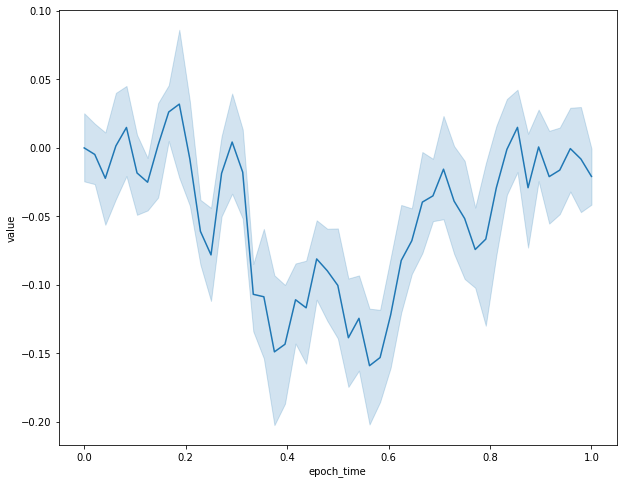

In [12]:
plt.subplots(figsize=(10, 8))
sns.lineplot(data=coef_df, x="epoch_time", y="value")

Nope, doesn't look right. We know the underlying response should peak at ~0.3 seconds. What we're seeing here conflates the response shape with the delayed onset of the response.

----

## EM regression with latent recognition

In [13]:
param_grid = [rr_em.get_parameters() for _ in range(50)]

In [14]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=50, trf_alpha=1e-2,
                                 early_stopping_patience=3)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
coef_df = pd.DataFrame(torch.stack(encoders)[:, :, 0])
coef_df.index.name = "iter"
coef_df = coef_df.reset_index().melt(id_vars=["iter"], var_name=["epoch_sample"])
coef_df["epoch_time"] = coef_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]
coef_df

,iter,epoch_sample,value,epoch_time
0,0,0,0.015598,0.0
1,1,0,-0.029300,0.0
2,2,0,-0.029300,0.0
3,3,0,-0.029300,0.0
4,4,0,-0.029300,0.0
...,...,...,...,...
70,0,14,0.008749,0.291667
71,1,14,0.011749,0.291667
72,2,14,0.011749,0.291667
73,3,14,0.011749,0.291667


<AxesSubplot:xlabel='epoch_time', ylabel='value'>

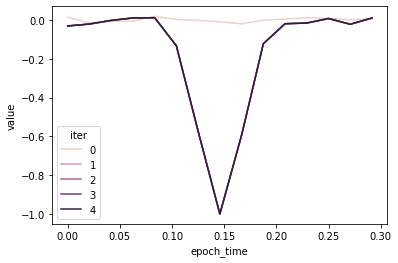

In [16]:
sns.lineplot(data=coef_df, x="epoch_time", y="value", hue="iter")

In [17]:
weights

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<AxesSubplot:xlabel='component', ylabel='value'>

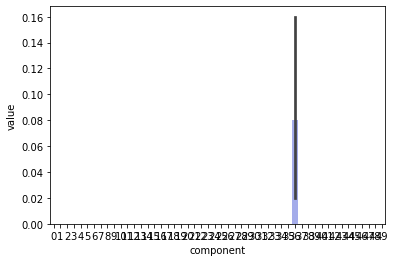

In [18]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

In [19]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [20]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0     0.457296
1     0.457296
2     0.457296
3     0.457296
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

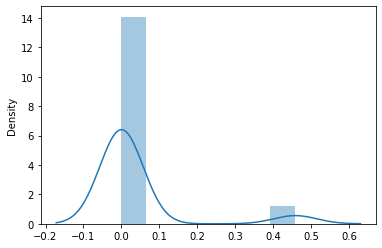

In [21]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [22]:
dataset.params.threshold

tensor(0.4555)